# Evaluation

In [9]:
import os
from collections import defaultdict
import polars as pl

results_checkov: list[pl.DataFrame] = []
results_tflint: list[pl.DataFrame] = []

for filename in os.listdir('results'):
    data = pl.read_json(f'results/{filename}')
    if filename.startswith('checkov'):
        results_checkov.append(data)
    elif filename.startswith('tflint'):
        results_tflint.append(data)

In [10]:
CHECKOV_PATTERNS = [
    'Object storage lifecycle rules',
    'AWS - Expensive DynamoDB',
    'Old generation',
]

TFLINT_PATTERNS = [
    'Budget',
    'Object storage lifecycle rules',
    'Old generation',
    'AWS - Expensive DynamoDB',
]

## Precision/recall

### Checkov

#### Before

In [11]:
checkov_clean = results_checkov[0].filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, url, before, _ in checkov_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in CHECKOV_PATTERNS:
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1

        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1

            print('----------')
            print('false positive:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', file['lines'], '-', file['path'])

        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

            print('----------')
            print('false positive:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', file['lines'], '-', file['path'])

----------
false positive: https://github.com/alphagov/govuk-aws/commit/6cfda6ada5137b232ff442ae9f2aedc8520ee1b4
commit: 7ec1573417fff41cae5b2081b007447e7a432789
real: Old generation
matched: ['Old generation', 'Object storage lifecycle rules']
Old generation - [195, 209] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-apt/main.tf
Old generation - [205, 219] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-deploy/main.tf
Old generation - [131, 145] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-logs-cdn/main.tf


In [12]:
pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = checkov_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in CHECKOV_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern'))

shape: (3, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 3   ┆ 3   ┆ 24  ┆ 0   ┆ 0.111111  ┆ 1.0      │
│ AWS - Expensive DynamoDB       ┆ 23  ┆ 23  ┆ 5   ┆ 0   ┆ 0.821429  ┆ 1.0      │
│ Old generation                 ┆ 31  ┆ 16  ┆ 4   ┆ 15  ┆ 0.8       ┆ 0.516129 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


#### Before + after

In [13]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after in checkov_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in CHECKOV_PATTERNS:
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

In [23]:
pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = checkov_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in CHECKOV_PATTERNS
])
pr_df = pl.DataFrame(pr)

summary = counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')

print(summary)

shape: (3, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 3   ┆ 2   ┆ 24  ┆ 0   ┆ 0.076923  ┆ 1.0      │
│ AWS - Expensive DynamoDB       ┆ 23  ┆ 13  ┆ 3   ┆ 1   ┆ 0.8125    ┆ 0.928571 │
│ Old generation                 ┆ 31  ┆ 6   ┆ 9   ┆ 4   ┆ 0.4       ┆ 0.6      │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


### TFLint

#### Before

In [15]:
tflint_clean = results_tflint[0].filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, url, before, after in tflint_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in TFLINT_PATTERNS:
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1

        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1

            print('----------')
            print('false positive:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', 'start:', file['start'], 'end:', file['end'], '-', file['path'])

        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

            print('----------')
            print('false negative:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', 'start:', file['start'], 'end:', file['end'], '-', file['path'])

----------
false negative: https://github.com/nsbno/terraform-aws-cost-alarm/commit/7e135499d33f0a5c51602a506fefe258cac072c6
commit: a7890d10b370fb97fe57a18f7d1bfeedc49f99ae
real: Budget
matched: []
----------
false negative: https://github.com/64kramsystem/ultimate_aws_certified_cloud_practitioner_course_terraform_configuration/commit/2f36b8a5f2f818138da72d218c1f3c9666ed54aa
commit: 12b334b4a5eab43610932a844948d0eaba5267f3
real: Budget
matched: ['Old generation', 'Old generation', 'Old generation', 'Object storage lifecycle rules', 'Object storage lifecycle rules']
Old generation - start: {'line': 3, 'column': 3} end: {'line': 3, 'column': 29} - snapshots/64kramsystem-ultimate_aws_certified_cloud_practitioner_course_terraform_configuration-2f36b8a5f2f818138da72d218c1f3c9666ed54aa/before-12b334b4a5eab43610932a844948d0eaba5267f3/terraform/ec2_instances.london.tf
Old generation - start: {'line': 35, 'column': 3} end: {'line': 35, 'column': 29} - snapshots/64kramsystem-ultimate_aws_certif

In [16]:
pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = tflint_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in TFLINT_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(
    counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')
)

shape: (4, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Budget                         ┆ 15  ┆ 6   ┆ 15  ┆ 9   ┆ 0.285714  ┆ 0.4      │
│ Object storage lifecycle rules ┆ 2   ┆ 2   ┆ 12  ┆ 0   ┆ 0.142857  ┆ 1.0      │
│ Old generation                 ┆ 10  ┆ 6   ┆ 3   ┆ 4   ┆ 0.666667  ┆ 0.6      │
│ AWS - Expensive DynamoDB       ┆ 14  ┆ 13  ┆ 0   ┆ 1   ┆ 1.0       ┆ 0.928571 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


#### Before + after

In [17]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after in tflint_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in TFLINT_PATTERNS:
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

In [18]:
pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = tflint_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in TFLINT_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(
    counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')
)

shape: (4, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Budget                         ┆ 15  ┆ 6   ┆ 37  ┆ 9   ┆ 0.139535  ┆ 0.4      │
│ Object storage lifecycle rules ┆ 2   ┆ 2   ┆ 24  ┆ 0   ┆ 0.076923  ┆ 1.0      │
│ Old generation                 ┆ 10  ┆ 6   ┆ 9   ┆ 4   ┆ 0.4       ┆ 0.6      │
│ AWS - Expensive DynamoDB       ┆ 14  ┆ 13  ┆ 3   ┆ 1   ┆ 0.8125    ┆ 0.928571 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


### Overview

In [19]:
print(checkov_clean.group_by('pattern').len())
print(tflint_clean.group_by('pattern').len())

shape: (3, 2)
┌────────────────────────────────┬─────┐
│ pattern                        ┆ len │
│ ---                            ┆ --- │
│ str                            ┆ u32 │
╞════════════════════════════════╪═════╡
│ Old generation                 ┆ 31  │
│ AWS - Expensive DynamoDB       ┆ 23  │
│ Object storage lifecycle rules ┆ 3   │
└────────────────────────────────┴─────┘
shape: (4, 2)
┌────────────────────────────────┬─────┐
│ pattern                        ┆ len │
│ ---                            ┆ --- │
│ str                            ┆ u32 │
╞════════════════════════════════╪═════╡
│ Object storage lifecycle rules ┆ 2   │
│ Budget                         ┆ 15  │
│ AWS - Expensive DynamoDB       ┆ 14  │
│ Old generation                 ┆ 10  │
└────────────────────────────────┴─────┘


## Performance

[[37.601713203126565, 5.0001204560976475, 4.215749223949388, 3.9841895301360637, 4.757758043007925, 4.845154284033924, 4.82304499601014, 13.700759914005175, 16.175753680057824, 21.34585998998955, 43.27870494290255, 46.770036238012835, 42.625352766830474, 9.636164967902005, 5.128395166946575, 8.646269313059747, 5.043642048025504, 4.8696294710971415, 13.95993801788427, 5.925624943105504, 5.448769563110545, 10.707999730948359, 9.228677606908605, 5.668022379046306, 5.8691294498275965, 6.138988386839628, 14.809627423994243, 10.303860604995862, 10.57583831390366, 5.399821913801134, 7.8755566561594605, 5.434844141127542, 5.947769935941324, 6.062654321081936, None, 9.704417744884267, 11.231485994067043, 5.153931722976267, 7.95502323191613, 6.039494258817285, 38.36992693785578, 6.180785348173231, 313.37158033810556, 266.26646044198424, 402.38200233108364, 4.810264925006777, 4.891758057055995, 4.770422684960067, 4.993015032960102, 4.576505615143105, 5.739451905945316, 7.085938375908881, 5.053514

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

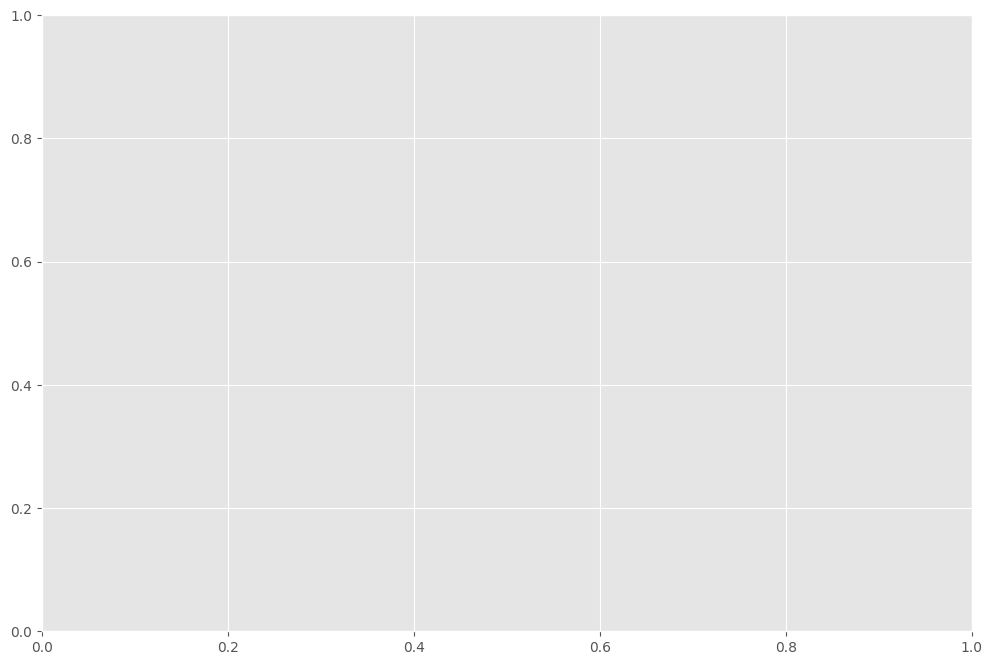

In [52]:
import matplotlib.pyplot as plt
import numpy as np

checkov_perf = {
    'before': results_checkov[0].select(duration=pl.col('before').list.get(0).struct.field('duration')).get_column('duration').to_list(),
    'after': results_checkov[0].select(duration=pl.col('after').struct.field('duration')).get_column('duration').to_list(),
    # 'latest': results_checkov[0].select(duration=pl.col('latest').struct.field('duration')).get_column('duration').to_list(),
}

tflint_perf = {
    'before': results_tflint[0].select(duration=pl.col('before').list.get(0).struct.field('duration')).get_column('duration').to_list(),
    'after': results_tflint[0].select(duration=pl.col('after').struct.field('duration')).get_column('duration').to_list(),
    # 'latest': results_tflint[0].select(duration=pl.col('latest').struct.field('duration')).get_column('duration').to_list(),
}

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 8))

keys = list(checkov_perf.keys())
data1 = [checkov_perf[k] + [np.nan] * (99 - 72 - 1) for k in keys]
data2 = [tflint_perf[k] for k in keys]

print(data1)
print(data2)

x1 = np.arange(len(keys)) * 2
x2 = np.arange(len(keys)) * 2 + 1

box1 = ax.boxplot(data1, positions=x1, widths=0.6, tick_labels=keys)
box2 = ax.boxplot(data2, positions=x2, widths=0.6, tick_labels=keys)

ax.set_xticks(np.arange(len(keys)) * 2 + 0.5)
ax.set_xticklabels(keys)
# ax.set_xlabel('Keys')
ax.set_ylabel('Duration (s)')
# ax.set_title('Comparison of Boxplots from Two Dictionaries')
ax.legend([box1["boxes"][0], box2["boxes"][0]], ['Checkov', 'TFLint'], loc='upper left')

plt.show()

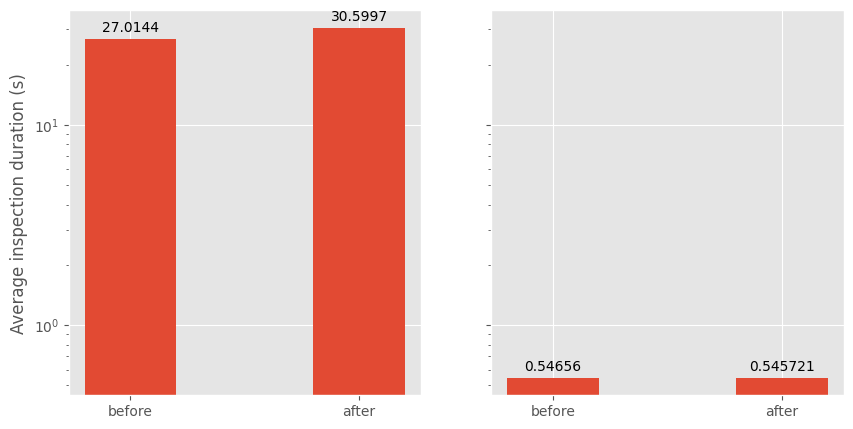

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import statistics

assert all(len(df) == len(results_checkov[0]) for df in results_checkov)
assert all(len(df) == len(results_tflint[0]) for df in results_tflint)

checkov_perf = {
    'before': statistics.mean([
        df.select(duration=pl.col('before').list.get(0).struct.field('duration')).sum().item()
        for df in results_checkov
    ]),
    'after': statistics.mean([
        df.select(duration=pl.col('after').struct.field('duration')).sum().item()
        for df in results_checkov
    ]),
    # 'latest': statistics.mean([
    #     df.select(duration=pl.col('latest').struct.field('duration'))
    #     for df in results_checkov
    # ]),
}
for k in checkov_perf.keys():
    checkov_perf[k] /= len(results_checkov[0])

tflint_perf = {
    'before': statistics.mean([
        df.select(duration=pl.col('before').list.get(0).struct.field('duration')).sum().item()
        for df in results_tflint
    ]),
    'after': statistics.mean([
        df.select(duration=pl.col('after').struct.field('duration')).sum().item()
        for df in results_tflint
    ]),
    # 'latest': statistics.mean([
    #     df.select(duration=pl.col('latest').struct.field('duration')).sum().item()
    #     for df in results_tflint
    # ]),
}
for k in tflint_perf.keys():
    tflint_perf[k] /= len(results_tflint[0])

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

bar_width = 0.4
x1 = np.arange(len(checkov_perf))
x2 = np.arange(len(tflint_perf)) + len(checkov_perf) + bar_width

bars1 = ax1.bar(x1, list(checkov_perf.values()), bar_width, label='Checkov')
ax1.bar_label(bars1, padding=3)
ax1.set_xticks(x1)
ax1.set_xticklabels(list(checkov_perf.keys()))
ax1.set_ylabel('Average inspection duration (s)')
ax1.set_yscale('log')

bars2 = ax2.bar(x2, list(tflint_perf.values()), bar_width, label='TFLint')
ax2.bar_label(bars2, padding=3)
ax2.set_xticks(x2)
ax2.set_xticklabels(list(tflint_perf.keys()))
ax2.set_yscale('log')

plt.show()

In [21]:
# import matplotlib.pyplot as plt

# checkov_timing_count = [
#     len(checkov_df),
#     2*len(checkov_df),
# ]
# checkov_timing_duration = [
#     checkov_df.select(
#         duration=pl.col('before').list.get(0).struct.field('duration')
#     ).sum().item(),
#     checkov_df.select(
#         duration=pl.col('before').list.get(0).struct.field('duration') + pl.col('after').struct.field('duration')
#     ).sum().item()
# ]

# tflint_timing_count = [
#     len(tflint_df),
#     2*len(tflint_df),
# ]
# tflint_timing_duration = [
#     tflint_df.select(
#         duration=pl.col('before').list.get(0).struct.field('duration')
#     ).sum().item(),
#     tflint_df.select(
#         duration=pl.col('before').list.get(0).struct.field('duration') + pl.col('after').struct.field('duration')
#     ).sum().item()
# ]

# _, ax1 = plt.subplots(figsize=(4, 4))
# ax1.set_xlabel('Number of repositories')
# ax1.set_ylabel('Inspection duration (s)')
# # ax1.set_xticks(checkov_timing_count)
# # ax1.set_yticks(checkov_timing_duration)
# rects = ax1.bar(
#     [str(x) for x in checkov_timing_count],
#     checkov_timing_duration,
#     width=0.2,
#     color=(0.9, 0.3, 0.3),
# )
# ax1.bar_label(rects, padding=3)
# ax1.set_xlim(-0.5, len(checkov_timing_count) - 0.5)
# ax1.set_ylim(0, checkov_timing_duration[-1] + 100)

# _, ax2 = plt.subplots(figsize=(4.2, 4))
# ax2.set_xlabel('Number of repositories')
# ax2.set_ylabel('Total duration (s)')
# # ax2.set_xticks(tflint_timing_count)
# # ax2.set_yticks(tflint_timing_duration)
# rects = ax2.bar(
#     [str(x) for x in tflint_timing_count],
#     tflint_timing_duration,
#     width=0.2,
#     color=(0.3, 0.3, 0.9),
# )
# ax2.bar_label(rects, padding=3)
# ax2.set_xlim(-0.5, len(tflint_timing_count) - 0.5)
# ax2.set_ylim(0, tflint_timing_duration[-1] + 10)